# Lecture 2: Numerical and graphical techniques (univariate)

## Lecture overview

1. [Plots of variables over time](#section1)
2. [Plots of variables as a function of themselves](#section2)
3. [Summary](#section3)

Before we jump into more rigorous mathematical analyses, we’re first going to learn how to get a feel for the dynamics of our models.

To do so we’re going to choose some particular numerical values for our parameters and then use our models to predict what happens over time.

The downside of this approach is that we often won’t know the parameter values to choose and, regardless, choosing particular values doesn’t tell us about the dynamics of our model more generally.

The upside is that this approach can highlight errors or reveal unexpected patterns that guide future mathematical analyses.

<span id='section1'></span>
## 1. Plots of variables over time
<hr>

The first plot is of the variables over time. We've already seen two examples of this in the previous lecture, for both evolution during extreme events and migration. In both cases we wrote recursive functions (actually, "generator"s in Python) to generate values of the variables at sequential time points.

Here let's look at a simpler example to demonstrate the essence of the method by hand. Take the recursion for the migration example $n(t+1) = (n(t)+M)(1+B-D-BD)$, ignore migration, $M=0$, and create a new parameter, $R=1+B-D-BD$. Our simplified recursion is then 

$n(t+1)=Rn(t)$.

This is called **exponential growth** (technically "geometric" growth in discrete time) and the only parameter of the model, $R$, is referred to as the reproductive value.

To plot a variable over time we

- choose an initial condition,
- choose parameter values, and
- numerically iterate the equation.

Here let's choose initial condition $n(0)=100$ and parameter value $R=2$. Now we can iterate:

$n(1) = Rn(0) = 2\times100 = 200$

$n(2) = Rn(1) = 2\times200 = 400$

$\vdots$

After doing this a few more times we can plot

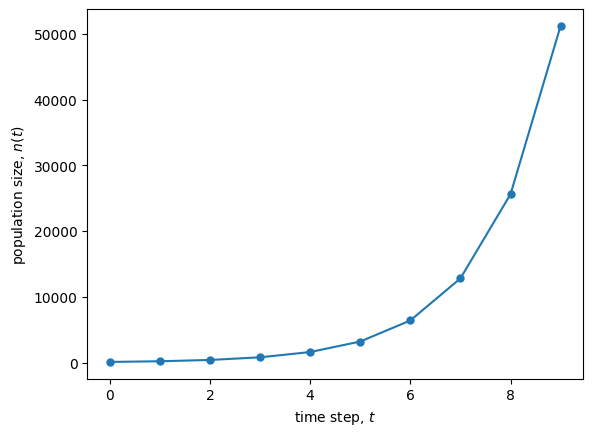

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# recursion
def exp_growth(n0, R, tmax):
    '''define generator for exponential growth'''
    
    # set initial values
    t,n=0,n0
    
    # yield new values
    while t < tmax:
        yield t,n
        
        # update values
        t += 1
        n = n * R

# evaluate 
tn = exp_growth(n0=100, R=2, tmax=10) #choose some parameter values and initial conditions
tns = np.array([vals for vals in tn]) #get all the t, n(t) values

# plot
fig, ax = plt.subplots()
ax.plot(tns[:,0], tns[:,1], marker = '.', markersize = 10)
ax.set_xlabel('time step, $t$')
ax.set_ylabel('population size, $n(t)$')
plt.show()

We can get a feel for the model by adjusting initial conditions and parameter values. What happens to the population size when you set $0<R<1$ in the code above?

<span id='section2'></span>
## 2. Plots of variables as a function of themselves
<hr>

OK, so now we’ll move on to a plot that is easier to generate and is very useful for models with just one variable (which is what we’ve been working with so far).

Instead of plotting the variable as a function of time, we’ll plot the variable as a function of the variable in the previous time, e.g., plotting $n(t+1)$ as a function of $n(t)$. We could do this for exponential growth but let's move on to something else for variety.

Consider a population with two types of individuals, $n_A(t)$ with allele $A$ and $n_a(t)$ with allele $a$. The frequency of $A$ in the population is $p(t) = \frac{n_a(t)}{n_A(t) + n_a(t)}$. This is the variable we wish to track.

Let’s assume that each individual with an $A$ leaves $W_A$ descendants in the next generation and each individual with an $a$ leaves $W_a$ descendants.
These $W_i$ are referred to as the **absolute fitnesses** as they determine the (absolute) numbers of individuals with a $A$ and a $a$ in the next generation, $n_i(t+1) = W_i n_i(t)$, for $i=A$ and $i=a$. The frequency of $A$ in the next generation is then

$$
\begin{aligned}
p(t+1) 
&= \frac{n_A(t+1)}{n_A(t+1) + n_a(t+1)} \\
&= \frac{W_A n_A(t)}{W_A n_A(t) + W_a n_a(t)} \\
&= \frac{W_A\frac{n_A(t)}{n_A(t) + n_a(t)}}{W_A\frac{n_A(t)}{n_A(t) + n_a(t)} + W_a\frac{n_a(t)}{n_A(t) + n_a(t)}}\\
&= \frac{W_A p(t)}{W_A p(t) + W_a (1-p(t))}.
\end{aligned}
$$

This is the recursion equation we want to plot. It is a classic model called **haploid selection**. Below is some code that plots $p(t+1)$ as a function of $p(t)$.

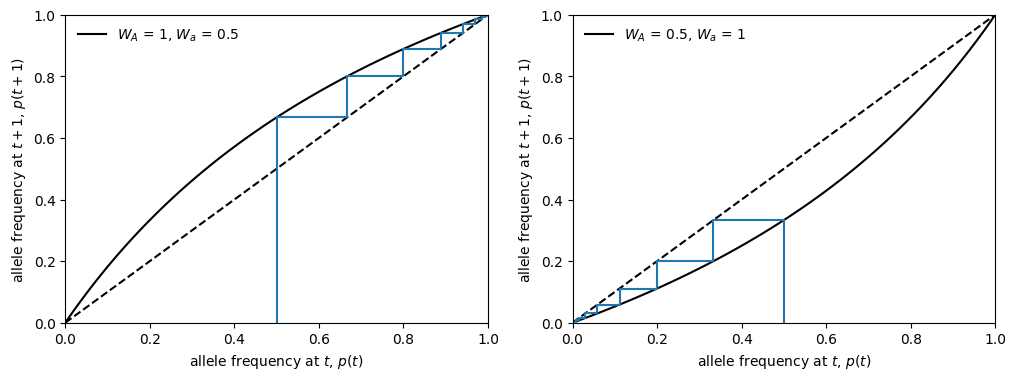

In [5]:
import sympy

# Build cobweb plotting function
def cobweb_haploid(p0, WA, Wa, max=np.inf):
    t, pnow, pnext = 0, p0, 0 #initial conditions
    while t <= max:
        yield pnow, pnext #current value of p(t) and p_(t+1)
        pnext = (WA * pnow) / (WA * pnow + Wa * (1 - pnow)) #update p_(t+1)
        yield pnow, pnext #current value of p(t) and p_(t+1)
        pnow = pnext #update p(t)
        t += 1 #update t
        
# Build function for generating figure
def plot_haploid_selection(WA, Wa, p0=0.5, ax=None):
    pt = sympy.symbols('pt') #define our variable p(t)

    # Write out sympy equation
    f = (WA * pt) / (WA * pt + Wa * (1 - pt)) #the recursion equation

    # Compute function over a set of points in [0,1] by 'lambdifying' sympy equation (turn it into a function)
    t = np.linspace(0,1,100)
    fy = sympy.lambdify(pt, f)(t)

    # Build plot
    if ax == None:
        fig, ax = plt.subplots()
    ax.plot(t, fy, color='black', label=f"$W_A$ = {WA}, $W_a$ = {Wa}") #plot p_(t+1) as function of p(t)
    ax.plot(t, t, color='black', linestyle='--') #draw 1:1 line for reference
    
    # Add cobweb
    cobweb = np.array([p for p in cobweb_haploid(p0, WA, Wa, max=100)])
    ax.plot(cobweb[:,0], cobweb[:,1])
    
    # Annotate and label plot
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel("allele frequency at $t$, $p(t)$")
    ax.set_ylabel("allele frequency at $t+1$, $p(t+1)$")
    ax.legend(frameon=False)
    return ax
        
# Plot figure
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

# First cobweb with WA > Wa
plot_haploid_selection(WA = 1, Wa = 0.5, ax=ax[0])

# Second cobweb with WA < Wa
plot_haploid_selection(WA = 0.5, Wa = 1, ax=ax[1])

plt.show()

There are three components to this plot. First, the solid curve gives the recursion itself ($p(t+1)$ as a function of $p(t)$). Second, the dashed line shows where $p(t+1)=p(t)$. And third, the blue lines show how the variable changes over multiple time steps. 

Foreshadowing what is to come, the dashed line is helpful for two reasons. First, it indicates where the variable does not change over time. So wherever the recursion (solid line) intersects with the dashed line is an **equilibrium**. Second, it reflects $p(t+1)$ back onto $p(t)$, updating the variable. For example, in the left panel above we start with an allele frequency of $p(t)=0.5$, draw a blue vertical line to the recursion to find $p(t+1)$, and then update $p(t)$ to $p(t+1)$ by drawing the horizontal blue line to the dashed line. Now we can ask what $p(t+1)$ is given this updated value of $p(t)$ by drawing another vertical blue line, and so on. Following the blue line we can therefore see where the system is heading, which tells us about the **stability** of the equilibria. 

What are the stable equilibria in the two panels above?

We can do something very similar for difference and differential equations. Now we plot the rate of change in the variable as a function of the current value of the variable, e.g., plot $\Delta n = n(t+1)-n(t)$ or $dn/dt$ as a function of $n(t)$.

Let's consider haploid selection in continuous time. To derive the differential equation let's first return to exponential growth and turn this into a difference equation,

$$
\begin{aligned}
n(t+1) &= R n(t)\\
n(t+1) - n(t) &= R n(t) - n(t)\\
\Delta n &= (R-1)n(t)
\end{aligned}
$$

Now recall that $R=1+B-D-BD$ so that $R-1=B-D-BD$. And let's consider a small timestep $\Delta t$ during which there are $B\Delta t$ births and $D\Delta t$ deaths per individual. Then the difference equation over this timestep, $\Delta n = n(t+\Delta t)-n(t)$ is,

$$
\Delta n = (B\Delta t - D\Delta t - BD(\Delta t)^2)n(t)
$$

We then divide both sides by $\Delta t$ and take the limit as $\Delta t\rightarrow 0$ to get the differential equation

$$
\begin{aligned}
\frac{\Delta n}{\Delta t} &= (B - D - BD\Delta t)n(t)\\
\lim_{\Delta t\rightarrow0}\frac{\Delta n}{\Delta t} &= (B - D)n(t)\\
\frac{\mathrm{d}n}{\mathrm{d}t} &= rn(t).
\end{aligned}
$$

This is exponential growth in continuous time where $r$ is the per capita growth rate.

Now, returning to haploid selection, consider that allele $A$ has growth rate $r_A$ and allele $a$ has growth rate $r_a$, this gives two differential equations for the respective population sizes

$$
\begin{aligned}
\frac{\mathrm{d}n_A}{\mathrm{d}t} &= r_An_A(t)\\
\frac{\mathrm{d}n_a}{\mathrm{d}t} &= r_an_a(t)\\
\end{aligned}
$$

We now summon up the qoutient rule from 1st year calculus to derive the differential equation for the frequency of $A$ over time

$$
\begin{aligned}
\frac{\mathrm{d}p}{\mathrm{d}t} &= \frac{\mathrm{d}}{\mathrm{d}t}\left(\frac{n_A(t)}{n_A(t)+n_a(t)}\right)\\
&= \frac{dn_A/dt(n_A(t)+n_a(t)) - n_A(t)(dn_A/dt+dn_a/dt)}{(n_A(t)+n_a(t))^2}\\
&= \frac{r_An_A(t)(n_A(t)+n_a(t)) - n_A(t)(r_An_A(t)+r_an_a(t))}{(n_A(t)+n_a(t))^2}\\
&= r_Ap(t) - p(t)(r_Ap(t)+r_a(1-p(t)))\\
&= p(t)(1 - p(t))(r_A - r_a)\\
&= p(t)(1 - p(t))s\\
\end{aligned}
$$

where $s=r_A-r_a$ is called the selection coefficient of $A$ relative to $a$. The plot of $dp/dt$ vs. $p$ is below.

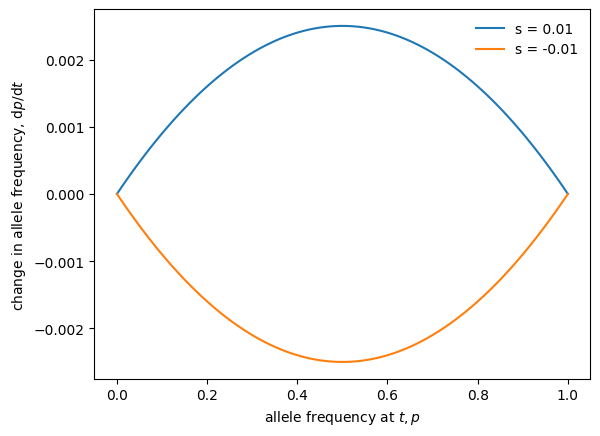

In [6]:
# Initialize sympy symbols
p0, s, t = sympy.symbols('p0, s, t')
p = sympy.Function('t')

# Specify differential equation
diffeq = sympy.Eq(p(t).diff(t), s * p(t) * (1 - p(t)))

# Convert differential equation RHS to pythonic function
dp = sympy.lambdify((s, p(t)), diffeq.rhs)

# Plot the curve
fig, ax = plt.subplots()

for s_coeff in [0.01, -0.01]:
    ax.plot(
        np.linspace(0, 1, 100),
        dp(s_coeff, np.linspace(0,1, 100)),
        label=f"s = {s_coeff}"
    )

ax.set_xlabel('allele frequency at $t, p$')
ax.set_ylabel('change in allele frequency, $\mathrm{d}p/\mathrm{d}t$')
ax.legend(frameon=False)
plt.show()

What does this tell us about how allele frequency will change when $s>0$ vs. $s<0$? And what allele frequencies, $p$, cause more rapid evolution?

Now let's simplify the above plots and just indicate the direction (and magnitude) of change in $p(t)$ with time. This is known as a **phase-line diagram**.

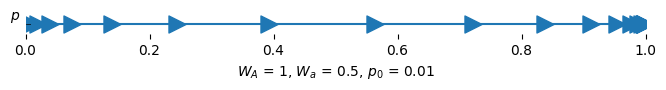

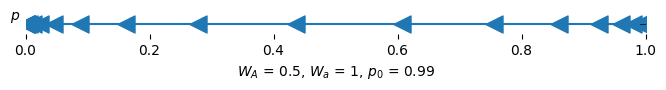

In [7]:
def phase_line_haploid(p0, WA, Wa, max=np.inf):
    'generator for p(t)'
    t, pnow, pnext = 0, p0, 0 #initial conditions
    while t < max:
        yield pnow #current value of p(t) and p_(t+1)
        pnext = (WA * pnow) / (WA * pnow + Wa * (1 - pnow))
        pnow = pnext #update p(t)
        t += 1 #update t

def plot_phase_line_haploid(WA, Wa, p0, max=20, ax=None):
    'plot phase line'
    
    # Set up figure
    if ax==None:
        fig, ax = plt.subplots()
        fig.set_size_inches(8,0.25)
    ax.axhline(0, color='black', linewidth=0.5)
    
    # Plot phase-line
    pts = [pt for pt in phase_line_haploid(p0, WA, Wa, max=max)] #pt values
    ax.plot(
        pts,
        np.zeros(max) #dummy y values (0 for all x values) because we want to plot a 1d line
    )
    
    # Plot vector field
    marker = '>' if pts[2] > pts[1] else '<' #determine which direction to point based on first 2 time points
    ax.scatter(
        pts,
        np.zeros(max),#dummy y again
        marker=marker, s=150
    )
    
    # Remove background axes
    ax.set_ylabel('$p$', rotation=0)
    ax.set_xlabel(f"$W_A$ = {WA}, $W_a$ = {Wa}, $p_0$ = {p0}")
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(0,1)
    plt.show()
    
plot_phase_line_haploid(WA=1, Wa=0.5, p0=0.01)

plot_phase_line_haploid(WA=0.5, Wa=1, p0=0.99)

As above, we see the frequency of $A$ approaches $p=1$ when $W_A>W_a$ (i.e., $s>0$) and $p=0$ when $W_a>W_A$ (i.e., $s<0$). We also notice, as above, the changes are fastest (fewer, longer arrows) at intermediate frequencies.

<span id='section3'></span>
## 3. Summary
<hr>

To get a feel for a model it is helpful to plot some numerical examples:

- plot the variable as a function of time ("simulate")
- plot the variable (or change in variable) as a function of itself

We've also just been introduced to two classic models in ecology and evolution, in both discrete and continuous time:

- exponential growth
- haploid selection